In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

# Convolutional Neural Networks

Convolution operator
- $(f * g)(x) = \int f(x)g(x-a)$
- $(f * g)(x) = \sum_a f(x)g(x-a)$



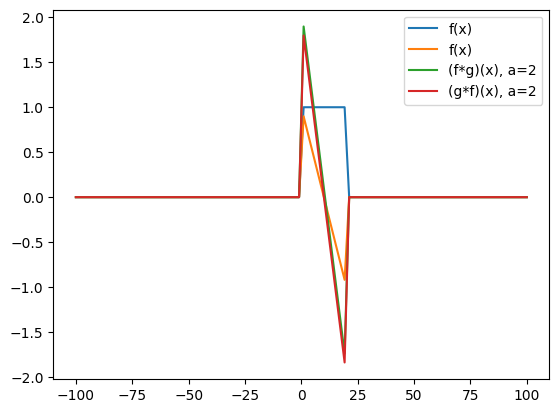

In [2]:
x = np.linspace(-100, 100, 100)

# f = lambda x: 3*np.exp(-(x-2)**2/2*0.1**2)
# g = lambda x: 2*np.exp(-(x-40)**2/2*0.05**2)
f = lambda x: np.where((x >= 0) & (x <= 20), 1, 0)
g = lambda x: np.where((x >= 0) & (x <= 20), 1-x/10, 0)

window = 2
conv_fg = []
conv_gf = []

for xi in x:
    f_gi = 0
    g_fi = 0
    for a in range(window):
        f_gi += f(xi) * g(xi-a)
        g_fi += g(xi) * f(xi-a)

    conv_fg.append(f_gi)
    conv_gf.append(g_fi)

plt.plot(x, f(x), label="f(x)")
plt.plot(x, g(x), label="f(x)")
plt.plot(x, conv_fg, label=f"(f*g)(x), a={window}")
plt.plot(x, conv_gf, label=f"(g*f)(x), a={window}")
plt.legend()


## Random kernel on random 2D input

(torch.Size([10, 10]), torch.Size([3, 3]), torch.Size([7, 7]))

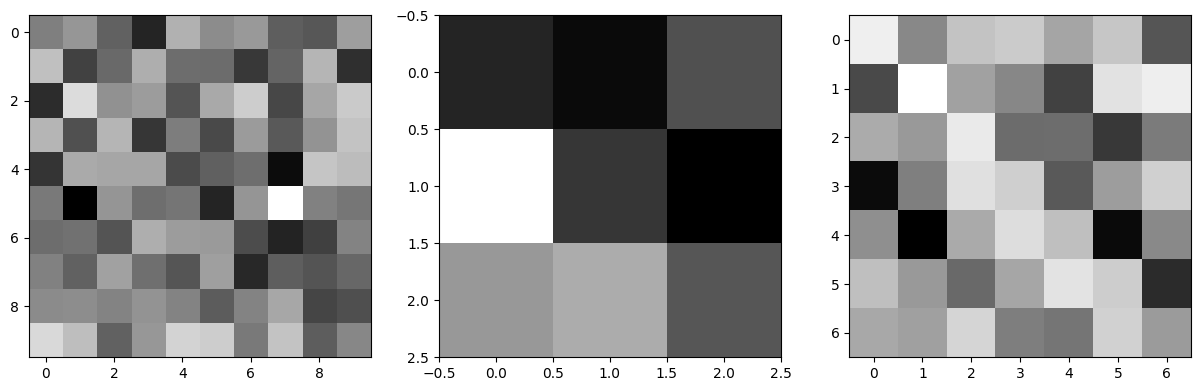

In [3]:
X = torch.randn(10, 10)
n = 3
kernel = torch.randn(n, n)

H = torch.zeros(10-n, 10-n)

for j in range(X.shape[0]-n):
    for i in range(X.shape[1]-n):
        H[j, i] = torch.sum(X[j:j+n, i:i+n] * kernel)
    
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(X, cmap="gray")
axes[1].imshow(kernel, cmap="gray")
axes[2].imshow(H, cmap="gray")

X.shape, kernel.shape, H.shape

## Random Kernel on image

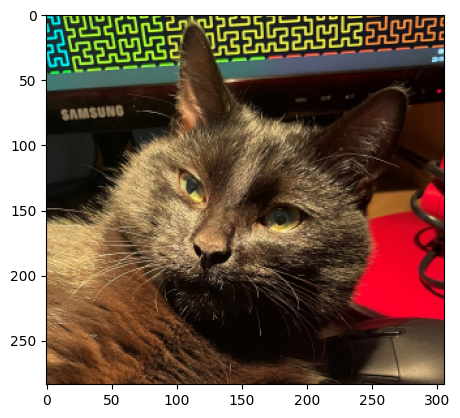

In [4]:
from PIL import Image

img = Image.open('../datasets/kat.png')
img.load()
img = torch.tensor(np.asarray(img, dtype='int32'))

plt.imshow(img, cmap="gray")

Text(0.5, 1.0, 'Conv2d')

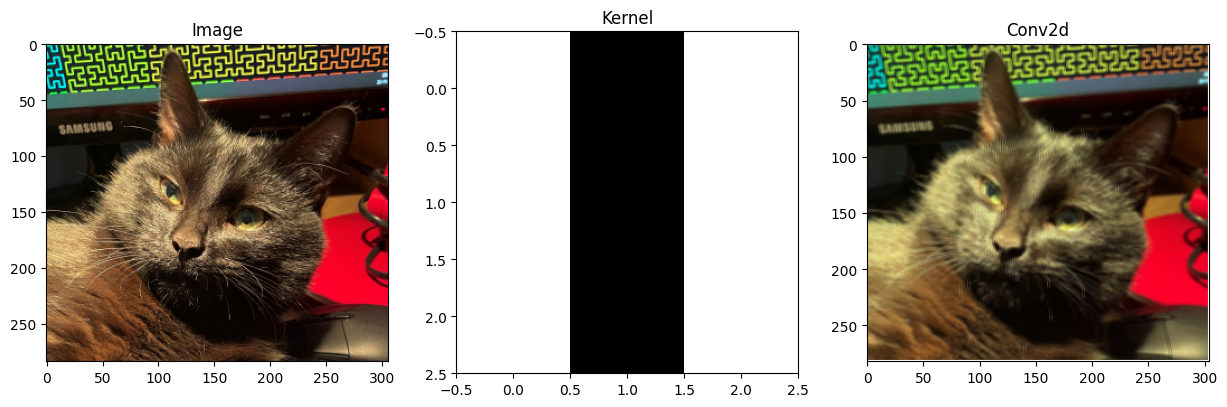

In [5]:
def map_val(x, in_min, in_max, out_min, out_max):
  return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

def convolution(X: torch.Tensor, kernel: torch.Tensor):
    
    h, w = kernel.shape
    H = torch.zeros(X.shape[0]-h+1, X.shape[1]-w+1, X.shape[2], dtype=torch.int32)
    
    for j in range(X.shape[0]-h):
        for i in range(X.shape[1]-w):
            for k in range(X.shape[2]):
                H[j, i, k] = torch.sum(X[j:j+h, i:i+w, k] * kernel)
    
    for k in range(X.shape[2]):
        H[:, :, k] = map_val(H[:, :, k], H[:, :, k].min(), H[:, :, k].max(), 0, 255).type(torch.int32)
    
    return H

n = 3
kernel = torch.tensor([
    [10, 0, 10],
    [10, 0, 10],
    [10, 0, 10]
])

# kernel = torch.randn(n, n)

H = convolution(img, kernel)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()
axes[0].imshow(img, cmap="gray")
axes[0].set_title("Image")
axes[1].imshow(kernel, cmap="gray")
axes[1].set_title("Kernel")
axes[2].imshow(H, cmap="gray")
axes[2].set_title("Conv2d")

## ConvLayer from Scratch

- Hidden unit shape after convolution (cross-correlation) $B \times C \times (H-k_h+p_h+s_h)/s_h \times (W-k_w+p_w+s_w)/s_w$, where:
    - $B$: batch size
    - $C$: number of channels
    - $H, W$: Height and Width of input
    - $(k_h, k_w)$: Kernel size (usually set to odd numbers)
    - $(p_h, p_w)$: padding size (usually padding size is $(k_h-1, k_w-1)$ if kernel size is odd)
    - $(s_h, s_w)$: stride size (usually set to 1)

In [6]:
class ConvLayerScratch(nn.Module):
    def __init__(self, 
                 num_input_channels: int, 
                 num_output_channels: int, 
                 kernel_shape: tuple[int, int] = (3, 3), 
                 padding: tuple[int, int] = (2, 2), 
                 stride: tuple[int, int] = (1, 1),
                 device = 'cpu'):
        super().__init__()
        self.padding = padding
        self.device = device
        self.stride = stride
        self.kernel_shape = kernel_shape
        self.kernel = nn.Parameter(torch.randn(num_output_channels, num_input_channels, *kernel_shape)).to(device)
        self.bias = nn.Parameter(torch.randn(num_output_channels, num_input_channels, 1, 1)).to(device)
    
    def corr2d(self, X: torch.Tensor, k_dim: int) -> torch.Tensor:
        # input: (batch_size, num_channels, height, width)
        ph, pw = self.padding
        sh, sw = self.stride
        kh, kw = self.kernel_shape
        X_padded = torch.zeros(X.shape[0], X.shape[1], X.shape[2]+2*ph, X.shape[3]+2*pw).to(self.device)
        X_padded[:, :, ph:-ph, pw:-pw] = X
        H = torch.zeros(*X_padded.shape[:2], (X_padded.shape[2]-kh+ph+sh)//sh, (X_padded.shape[3]-kw+pw+sw)//sw).to(self.device)

        for j in range(H.shape[2]):
            for i in range(H.shape[3]):
                for c in range(X.shape[1]):
                    try:
                        H[:, c, j, i] = torch.sum(X_padded[:, c, j*sh:j*sh+kh, i*sw:i*sw+kw] * self.kernel[k_dim, c, :, :])
                    except: # strided tensor size not the same as kernel size
                        pass
                    
        # output: (batch_size, num_channels, height, width)
        return H
    
    def forward(self, X):
        # concatenate output channels
        # (batch_size, out_channels, in_channels, height, width)
        H = torch.stack([self.corr2d(X, k_dim) for k_dim in range(self.kernel.shape[0])], dim=1)
        
        # output: (batch_size, out_channels, height, width)
        return (H + self.bias).sum(dim=2)

conv = ConvLayerScratch(num_output_channels=8, num_input_channels=4, kernel_shape=(5, 5), padding=(4, 4), stride=(2, 2), device='cuda')
X = torch.randn(1, 4, 23, 12).to('cuda')
Y = conv(X)
Y.shape

torch.Size([1, 8, 16, 10])

In [7]:
num_out_channels = 10

conv = ConvLayerScratch(num_output_channels=num_out_channels, num_input_channels=4, kernel_shape=(3, 3), padding=(4, 4), stride=(3, 3))
X = img.permute(2, 0, 1)[None, :]
Y = conv(X)
Y[:] = map_val(Y[:], Y[:].min(), Y[:].max(), 0, 255)
Y = Y.type(torch.int32)
X.shape, Y.shape

(torch.Size([1, 4, 284, 306]), torch.Size([1, 10, 98, 106]))

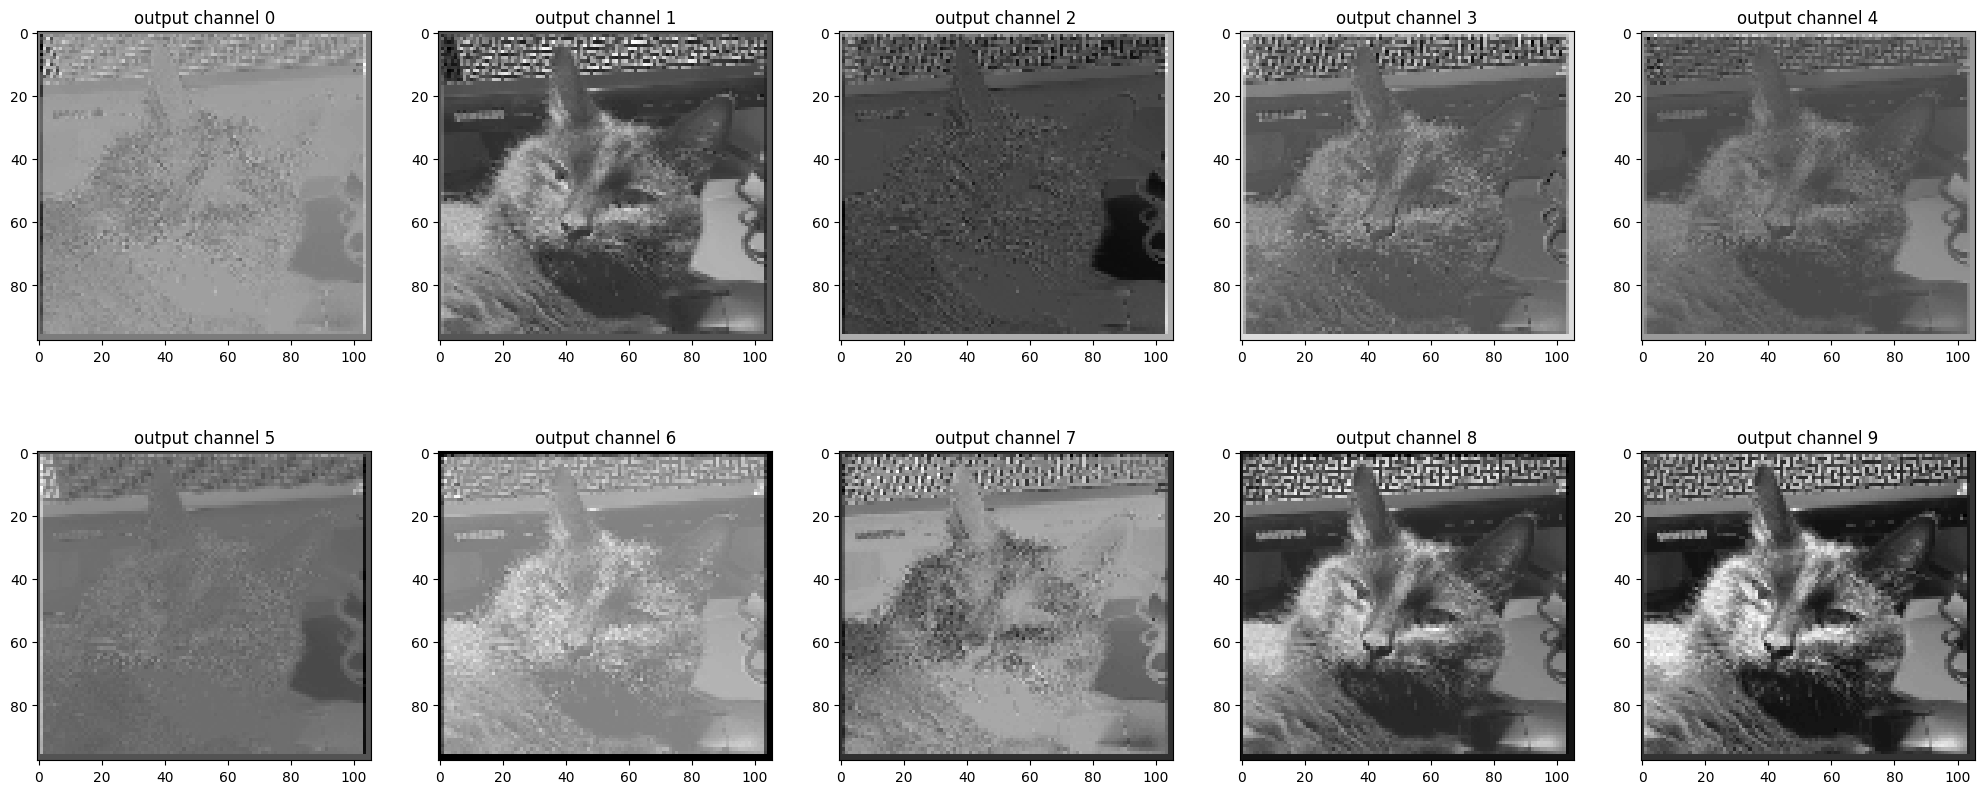

In [8]:

num_rows = num_out_channels // 5

fig, axes = plt.subplots(num_rows, 5, figsize=(5*5, 5*num_rows))
axes = axes.flatten()

Y_squeezed = Y.squeeze()
for ax, dim in zip(axes, range(Y.shape[1])):
    ax.set_title(f"output channel {dim}")
    ax.imshow(Y_squeezed[dim].detach().numpy(), cmap='gray')

## Pooling layers

- max-pooling: take maximum of adjacent pixels
- average-pooling: take average of adjacent pixels

In [9]:
from typing import Literal

class PoolingLayerScratch(nn.Module):
    def __init__(self, 
                 pooling_size: tuple[int, int] = (2, 2), 
                 padding: tuple[int, int] = (1, 1), 
                 stride: tuple[int, int] = (1, 1), 
                 operation: Literal['max', 'avg'] = 'max',
                 device = 'cpu'):
        super().__init__()
        self.device = device
        self.padding = padding
        self.pooling_size = pooling_size
        self.stride = stride
        self.operation = operation
    
    def pooling(self, X) -> torch.Tensor:
        # input: (batch_size, num_channels, height, width)
        plh, plw = self.pooling_size
        sh, sw = self.stride
        ph, pw = self.padding
        
        X_padded = torch.zeros(X.shape[0], X.shape[1], X.shape[2]+2*ph, X.shape[3]+2*pw).to(self.device)
        X_padded[:, :, ph:-ph, pw:-pw] = X
        
        H = torch.zeros(*X.shape[:2], (X.shape[2]-plh+ph+sh)//sh, (X.shape[3]-plw+pw+sw)//sw).to(self.device)
            
        oper = torch.max if self.operation == 'max' else lambda x: torch.mean(x, dtype=torch.float32)
        for j in range(H.shape[2]):
            for i in range(H.shape[3]):
                for c in range(X.shape[1]):
                    try:
                        H[:, c, j, i] = oper(X_padded[:, c, j*sh:j*sh+plh, i*sw:i*sw+plw])
                    except: # strided tensor size not the same as kernel size
                        pass
                    
        # output: (batch_size, num_channels, height, width)
        return H
    
    def forward(self, X):
        return self.pooling(X)

max_pooling = PoolingLayerScratch(pooling_size=(3, 3), stride=(1, 1), padding=(1, 1), operation='max')
# avg_pooling = PoolingLayerScratch(pooling_size=(2, 2), stride=(1, 1), padding=(1, 1), operation='avg')
X = torch.tensor([
    [1, 2, 3, 4, 5],
    [9, 2, 8, 4, 6]
]).reshape(1, 1, 2, 5)

Y_max = max_pooling(X)
Y_max
# Y_avg = avg_pooling(X)
# Y_max, Y_avg

tensor([[[[9., 9., 8., 8.]]]])

In [10]:
max_pooling = PoolingLayerScratch(pooling_size=(3, 3), stride=(2, 2), padding=(5, 5), operation='max')

X = torch.randn(1, 1, 4, 4)
Y_max = max_pooling(X)
Y_max

tensor([[[[0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.7932, 2.9605],
          [0.0000, 0.0000, 0.6112, 2.9605]]]])

## LeNet Convolutional Neural Network

In [2]:
class LeNetScratch(nn.Module):
    def __init__(self, num_input_channels: int, num_classes: int, device: 'cpu'):
        super().__init__()
        self.device = device
        self.net = nn.Sequential(
            ConvLayerScratch(num_input_channels=num_input_channels, num_output_channels=6, kernel_shape=(5, 5), padding=(2, 2), device=device),
            nn.Sigmoid(),
            PoolingLayerScratch(pooling_size=(2, 2), stride=(2, 2), operation='avg', device=device),
            ConvLayerScratch(num_input_channels=6, num_output_channels=16, kernel_shape=(5, 5), padding=(1, 1), device=device),
            nn.Sigmoid(),
            PoolingLayerScratch(pooling_size=(2, 2), stride=(2, 2), operation='avg', device=device),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes)
        ).to(device)
    
    def forward(self, X):
        return self.net(X)

class LeNet5(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.net = nn.Sequential(
            self.layer1, self.layer2,
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes)
        )
    
    def forward(self, X):
        return self.net(X)

class LeNet(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.LazyConv2d(out_channels=6, kernel_size=5, stride=1, padding=0),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes)
        )
    
    def forward(self, X):
        return self.net(X)

X = torch.randn(1, 1, 28, 28).to('cuda')
model = LeNet(num_classes=10).to('cuda')
model(X).shape

C:\Users\janba\python-dev\deeplearning_notebooks\venv\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([1, 10])

### Load train/test sets

In [3]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

train_set = torchvision.datasets.MNIST(root="../datasets", train=True, download=True, transform=transform)

test_val_set = torchvision.datasets.MNIST(root="../datasets", train=False, download=True, transform=transform)
X_test_val, y_test_val = zip(*test_val_set)
X_test_val = torch.stack(X_test_val)
y_test_val = torch.tensor(y_test_val)

test_idx, val_idx = torch.utils.data.random_split(y_test_val, [5000, 5000])

X_test = X_test_val[test_idx.indices]
y_test = y_test_val[test_idx.indices]

X_val = X_test_val[val_idx.indices]
y_val = y_test_val[val_idx.indices]

train_set.data.shape, train_set.targets.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

(torch.Size([60000, 28, 28]),
 torch.Size([60000]),
 torch.Size([5000, 1, 28, 28]),
 torch.Size([5000]),
 torch.Size([5000, 1, 28, 28]),
 torch.Size([5000]))

### Training loop

In [4]:
EPOCHS = 10

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

lenet = LeNet(num_classes=10).to('cuda')

optimizer = torch.optim.Adam(lenet.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_history = []
val_history = []

for epoch in range(EPOCHS):
    batch_history = []
    for i, (images, labels) in enumerate(train_loader):
        # predict and compute loss
        preds = lenet(images.to('cuda'))
        loss = criterion(preds, labels.to('cuda'))
        batch_history.append(loss.item())
        # optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_history.append(torch.mean(torch.tensor(batch_history)))

    with torch.no_grad():
        preds = lenet(X_val.to('cuda'))
        loss = criterion(preds, y_val.to('cuda'))
        val_history.append(loss.item())
    
    print(f"epoch {epoch}, train_loss {train_history[-1]}, val_loss {val_history[-1]}")

with torch.no_grad():
    preds = lenet(X_test.to('cuda'))
    loss = criterion(preds, y_test.to('cuda'))
    print(f"test_loss {loss.item()}")

C:\Users\janba\python-dev\deeplearning_notebooks\venv\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


epoch 0, train_loss 0.9916334748268127, val_loss 0.22307956218719482
epoch 1, train_loss 0.1650661677122116, val_loss 0.10994536429643631
epoch 2, train_loss 0.10653801262378693, val_loss 0.08135277032852173
epoch 3, train_loss 0.08385322988033295, val_loss 0.06659045070409775
epoch 4, train_loss 0.07003263384103775, val_loss 0.0559258833527565
epoch 5, train_loss 0.05968525633215904, val_loss 0.05565062165260315
epoch 6, train_loss 0.05219797417521477, val_loss 0.04964639991521835
epoch 7, train_loss 0.04660271853208542, val_loss 0.04521481320261955
epoch 8, train_loss 0.04113546386361122, val_loss 0.04671208932995796
epoch 9, train_loss 0.037510234862565994, val_loss 0.04248378798365593
test_loss 0.0451345220208168


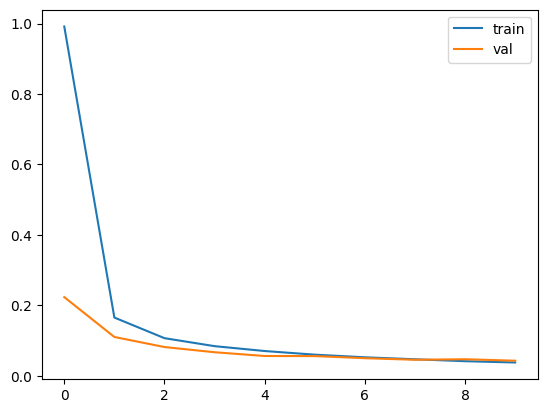

In [5]:
plt.plot(train_history, label='train')
plt.plot(val_history, label='val')
plt.legend()

### Visualize conv layers 

In [6]:
features = {} #dictionary that will store results!

def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

hook_handles = []

In [7]:
for i, m in enumerate(lenet.net.children()):
    h = m.register_forward_hook(get_features(f"{i}{type(m).__name__}"))
    hook_handles.append(h)

In [8]:
hook_handles

tensor([[-4.9322, -2.7213, -4.9904, -8.8551,  9.4206, -4.3315, -1.2966, -3.8282,
         -2.1615,  0.6673]], device='cuda:0', grad_fn=<AddmmBackward0>)

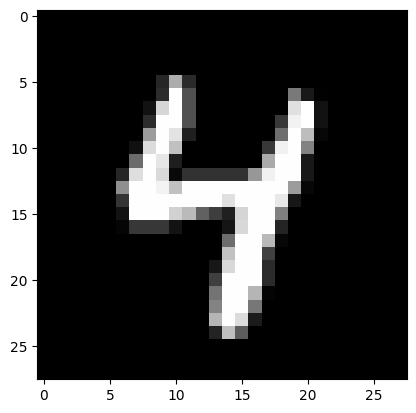

In [11]:
idx = 51

y_pred = lenet(X_test[idx][None, :].to('cuda'))

plt.imshow(X_test[idx][None, :].squeeze(), cmap='gray')
y_pred

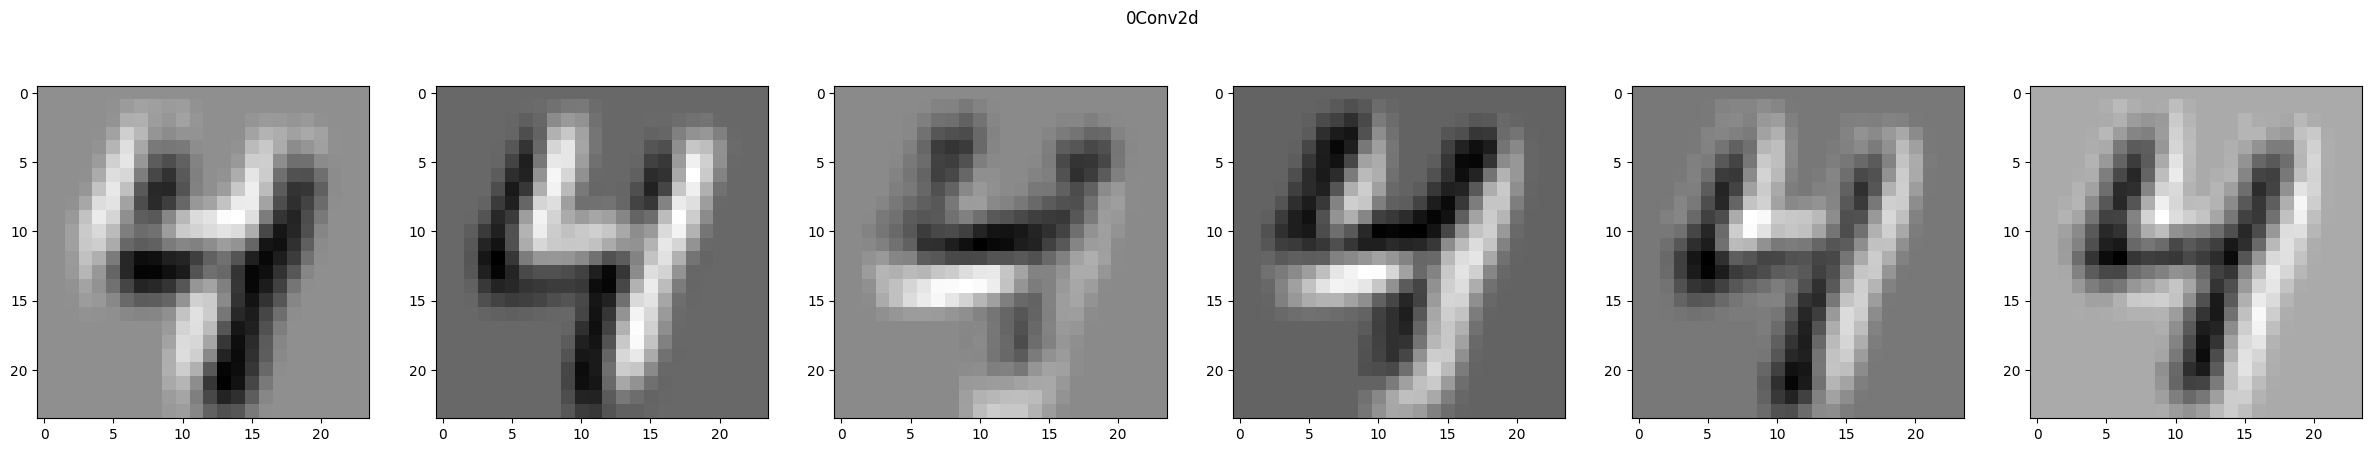

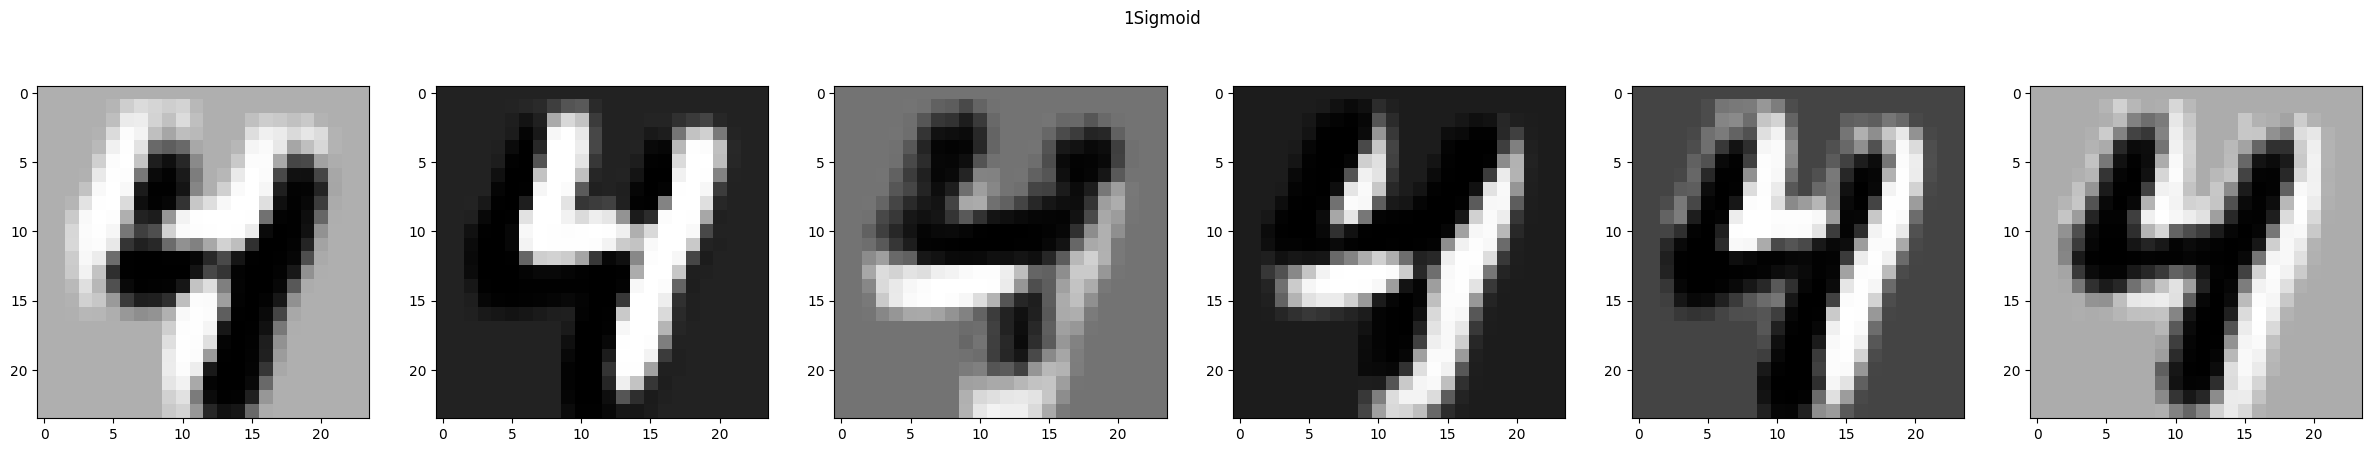

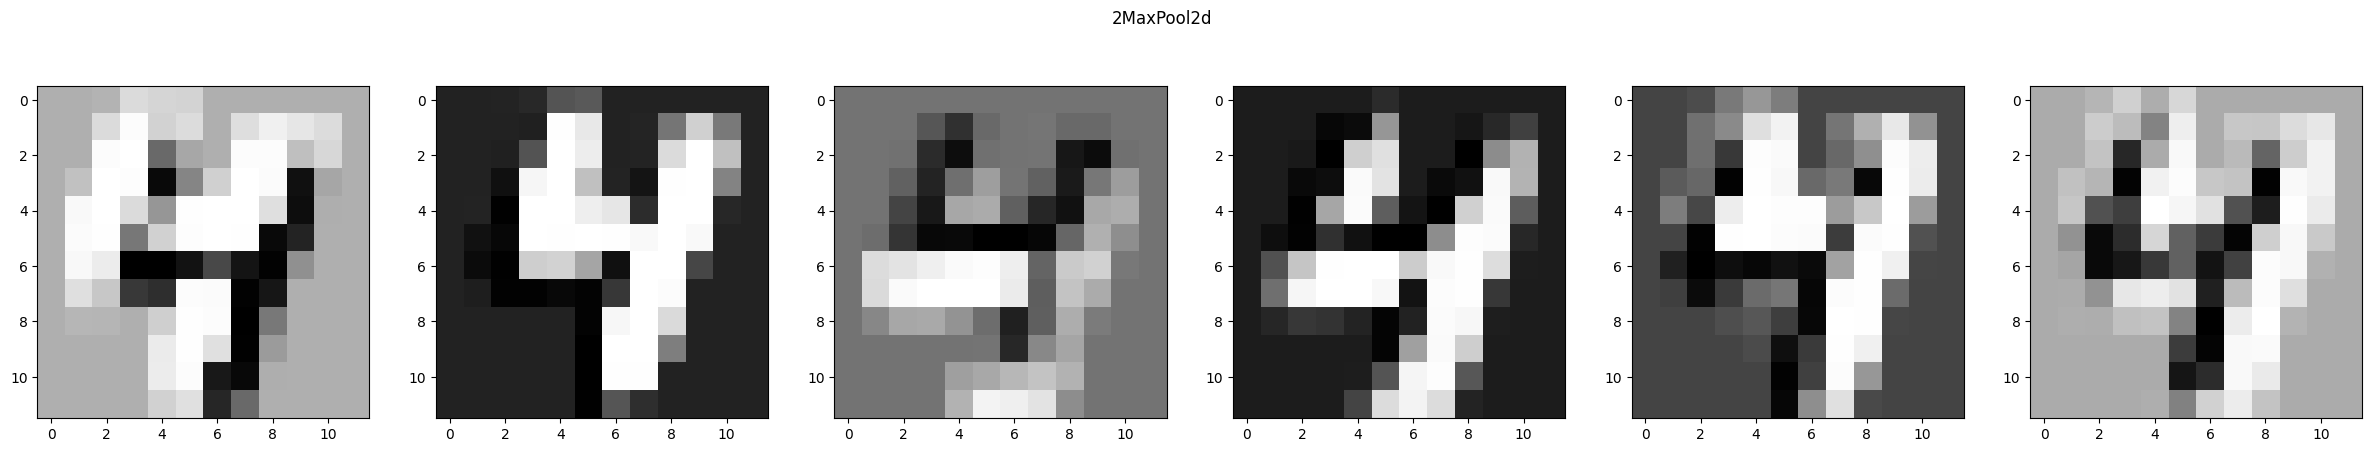

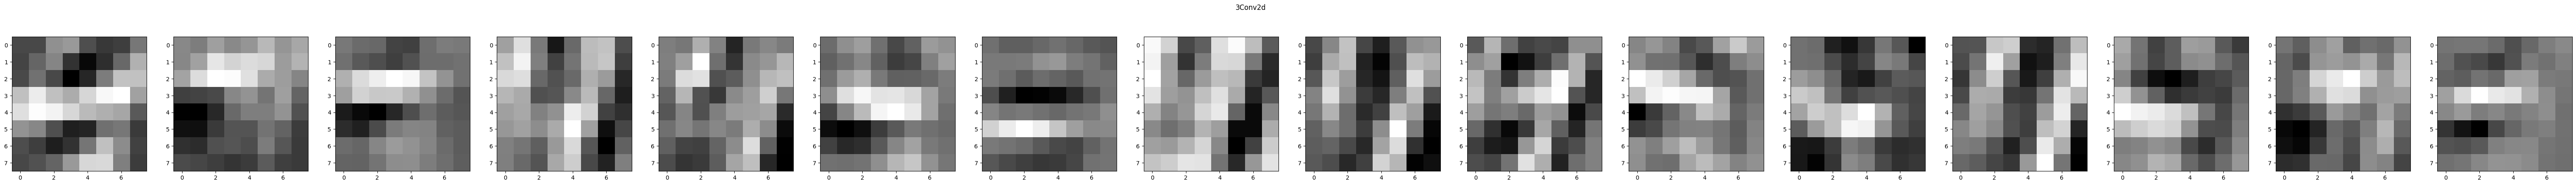

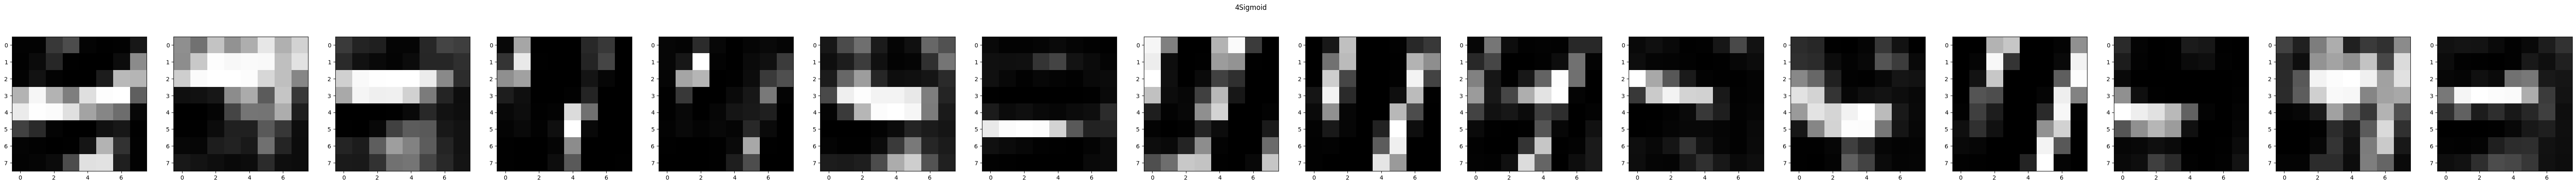

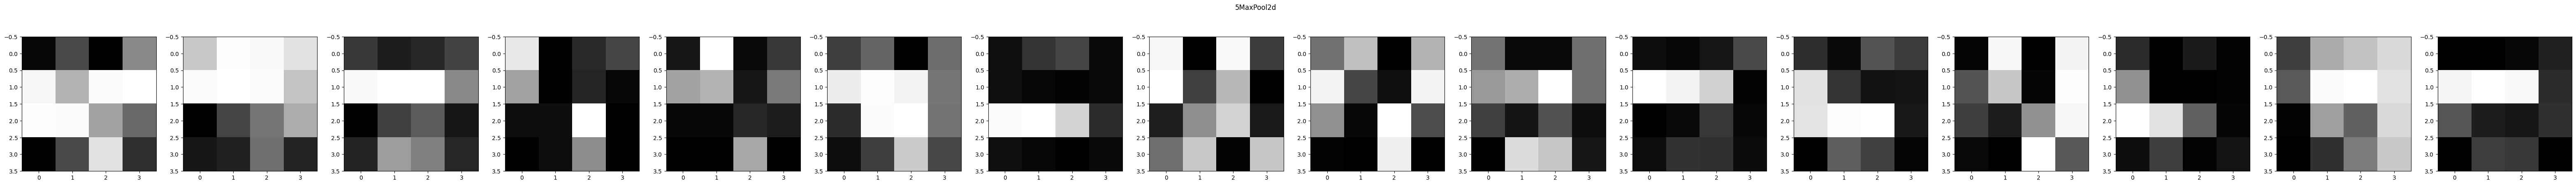

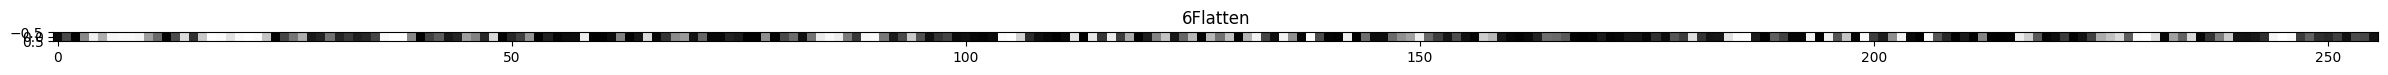

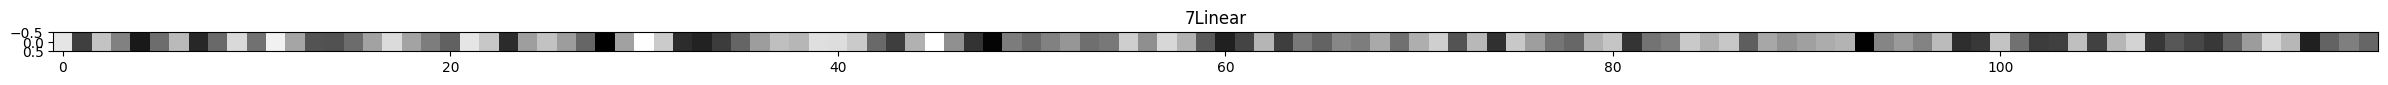

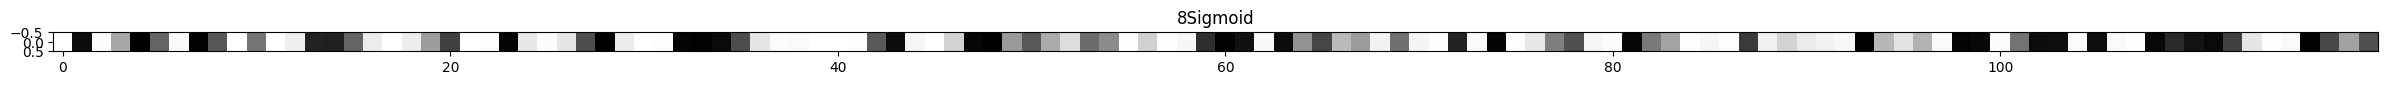

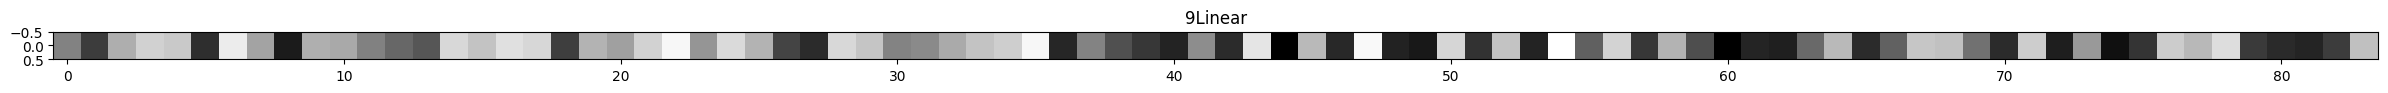

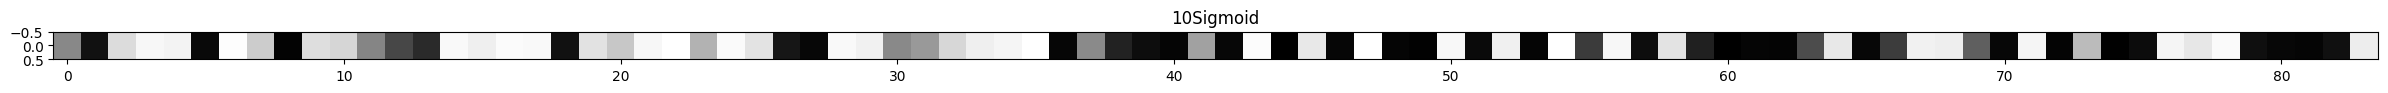

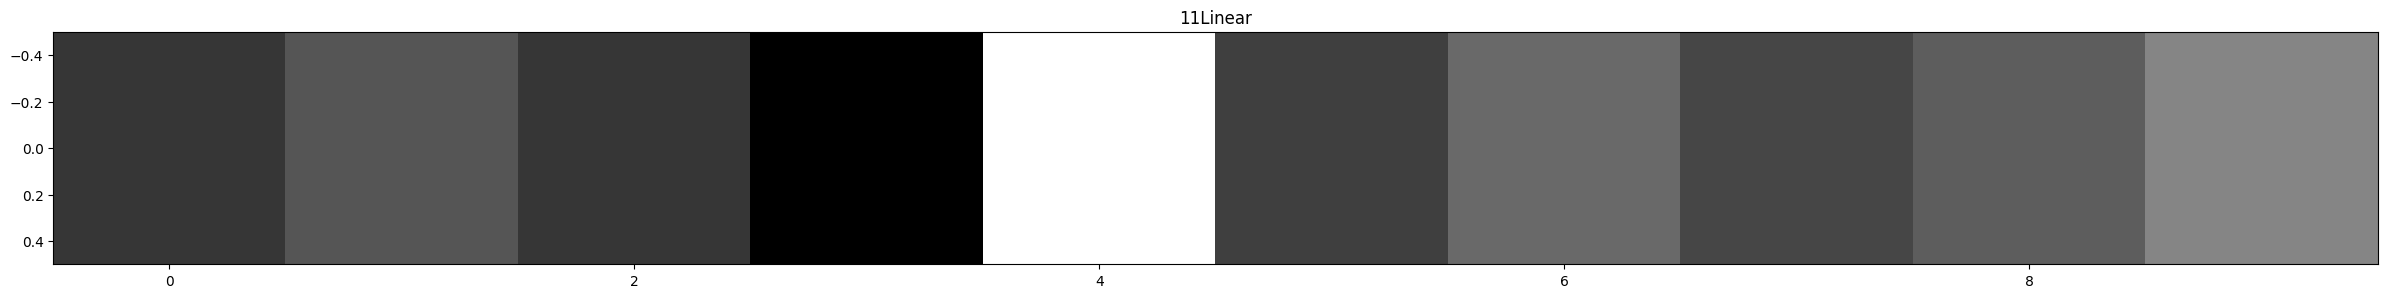

In [12]:
for name in features.keys():
    tensor = features[name].squeeze()
    if len(tensor.shape) > 1:
        fig, axes = plt.subplots(1, tensor.shape[0], figsize=(tensor.shape[0]*5, 5))
        axes = axes.flatten()
        fig.suptitle(name)
        for ax, conv_val in zip(axes, tensor):
            ax.imshow(conv_val.cpu().detach(), cmap='gray')
    else:
        plt.figure(figsize=(30, 5))
        plt.title(name)
        plt.imshow(tensor[None, :].cpu().detach(), cmap='gray')

### PCA of last hidden layer

In [ ]:
h = lenet.net[10].register_forward_hook(get_features(f"last_layer"))
hook_handles.append(h)

Text(0.5, 1.0, 'Last hidden layer projected onto 2 PCs')

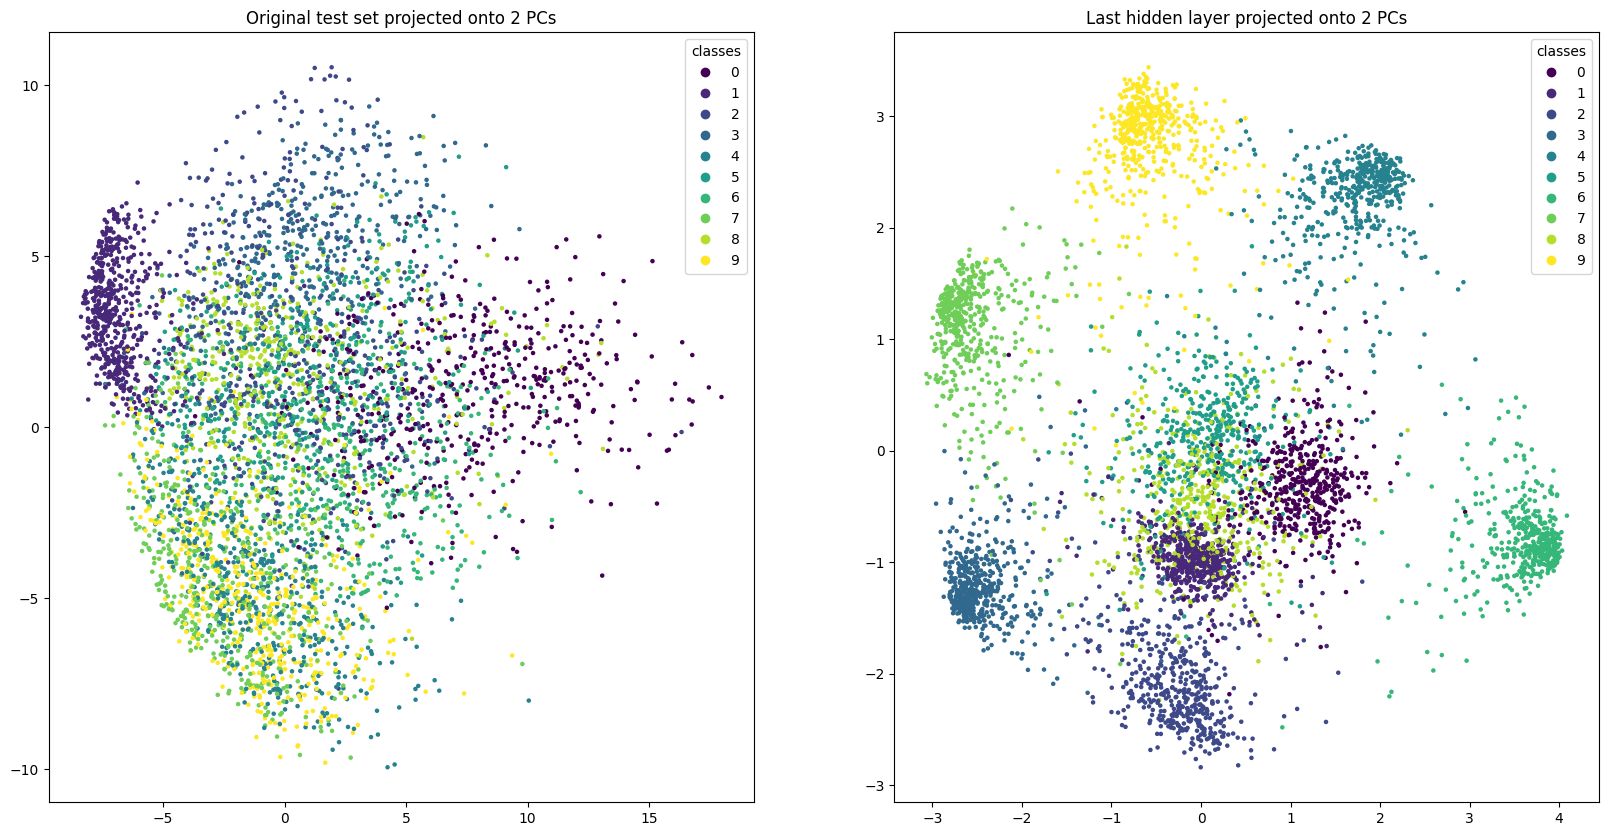

In [58]:
from sklearn.decomposition import PCA

X_pca = PCA(n_components=2).fit_transform(X_test.reshape((5000, -1)))
lenet(X_test.to('cuda'))
hidden_X_pca = PCA(n_components=2).fit_transform(features['last_layer'].cpu().detach().numpy().reshape((5000, -1)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
sc1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=y_test.numpy().tolist(), s=5)
ax1.legend(*sc1.legend_elements(), title='classes')
ax1.set_title('Original test set projected onto 2 PCs')

sc2 = ax2.scatter(hidden_X_pca[:, 0], hidden_X_pca[:, 1], c=y_test.numpy().tolist(), s=5)
ax2.legend(*sc2.legend_elements(), title='classes')
ax2.set_title('Last hidden layer projected onto 2 PCs')